# Downsample & mix

In [2]:
%matplotlib inline
%config InlineBackend.figure_format='retina'

import pandas as pd
import seaborn as sns
from IPython.display import display
from tqdm.auto import tqdm

sns.set_style("whitegrid")
import matplotlib.pyplot as plt
import numpy as np
import os
import re
from itertools import product
import tempfile

In [3]:
def bedl(file):
    try:
        tf = pd.read_csv(file, sep='\t', header=None)
        return tf[2] - tf[1]
    except:
        return np.zeros(0)  # Empty file


def lines(file):
    try:
        tf = pd.read_csv(file, sep='\t', header=None)
        return len(tf)
    except:
        return 0  # Empty file


def d(a, b):
    return a / b if b != 0 else 0


def last_col(file):
    try:
        cols = len(pd.read_csv(file, sep='\t', nrows=1, header=None).columns)
        return pd.read_csv(file, sep='\t', header=None, usecols=[cols - 1])[cols - 1]
    except:
        return np.zeros(0)  # Empty file


def sorted_file(file):
    ts = tempfile.mktemp()
    ! cat {file} | sort -k1,1 -k2,2n -k3,3n > {ts}
    return ts

# Load hg38 peaks


In [4]:
GSE26320_PATH = os.path.expanduser('~/data/2023_GSE26320')
GSE26320_CELLS = ['GM12878', 'HMEC', 'HSMM', 'K562', 'NHEK', 'NHLF', 'H1', 'Huvec', 'HepG2']
MODIFICATIONS = ['H3K4me3', 'H3K27ac', 'H3K4me1', 'H3K27me3', 'H3K36me3']
GSE26320_REPS = ['rep1', 'rep2']

IMMUNE_PATH = os.path.expanduser('~/data/2023_Immune')
IMMUNE_CELLS = ['CD4ABT', 'TCellBB', 'BCell', 'TCell', 'Monocyte', 'PBMC', 'NK', 'CD34', 'CD4', ]  ## Longest first
IMMUNE_REPS = ['rep1', 'rep2', 'rep3', '']

! mkdir -p {GSE26320_PATH}/pics
! mkdir -p {IMMUNE_PATH}/pics

In [5]:
TOOLS = ['MACS2', 'MACS2 broad', 'SPAN', 'SICER']
palette = plt.cm.get_cmap('tab10')
TOOLS_PALETTE = {t: palette(i) for i, t in enumerate(TOOLS)}

In [6]:
def load_peaks(path, suffix, modifications, cells, replicates):
    df = pd.DataFrame(columns=['file', 'modification', 'cell', 'replicate', 'peaks'],
                      dtype=object)
    for f in tqdm(os.listdir(path)):
        if not f.endswith(suffix):
            continue
        cell = next((c for c in cells if c in f), None)
        mod = next((m for m in modifications if m in f), None)
        rep = next((r for r in replicates if r in f), None)
        if cell and mod and rep is not None:
            peaks_path = os.path.join(path, f)
            ps = lines(peaks_path)
            df.loc[len(df)] = (peaks_path, mod, cell, rep, ps)
    return df

In [7]:
def load_peaks_path(path, modifications, cells, replicates):
    df_macs2 = load_peaks(os.path.join(path, 'macs2'), '.narrowPeak', modifications, cells, replicates)
    df_macs2['tool'] = 'MACS2'
    print('MACS2', len(df_macs2))

    df_macs2broad = load_peaks(os.path.join(path, 'macs2'), '.broadPeak', modifications, cells, replicates)
    df_macs2broad['tool'] = 'MACS2 broad'
    print('MACS2 broad', len(df_macs2broad))

    df_sicer = load_peaks(os.path.join(path, 'sicer'), 'summary-FDR0.01', modifications, cells, replicates)
    df_sicer['tool'] = 'SICER'
    print('SICER', len(df_sicer))

    df_span = load_peaks(os.path.join(path, 'span'), '.peak', modifications, cells, replicates)
    df_span['tool'] = 'SPAN'
    print('SPAN', len(df_span))

    return pd.concat([df_macs2, df_macs2broad, df_sicer, df_span]).reset_index(drop=True)

In [80]:
df_encode_peaks = load_peaks_path(GSE26320_PATH, MODIFICATIONS, GSE26320_CELLS, GSE26320_REPS)
df_encode_peaks['dataset'] = 'ENCODE'
df_encode_peaks.sample(5)

  0%|          | 0/680 [00:00<?, ?it/s]

MACS2 85


  0%|          | 0/680 [00:00<?, ?it/s]

MACS2 broad 85


  0%|          | 0/85 [00:00<?, ?it/s]

SICER 85


  0%|          | 0/88 [00:00<?, ?it/s]

SPAN 85


,file,modification,cell,replicate,peaks,tool,dataset
74,/home/jetbrains/data/2023_GSE26320/macs2/GSM64...,H3K36me3,GM12878,rep1,1741,MACS2,ENCODE
219,/home/jetbrains/data/2023_GSE26320/sicer/GSM64...,H3K4me3,HepG2,rep2,30452,SICER,ENCODE
262,/home/jetbrains/data/2023_GSE26320/span/GSM646...,H3K27ac,Huvec,rep2,38589,SPAN,ENCODE
166,/home/jetbrains/data/2023_GSE26320/macs2/GSM64...,H3K4me3,H1,rep2,15228,MACS2 broad,ENCODE
55,/home/jetbrains/data/2023_GSE26320/macs2/GSM64...,H3K4me1,K562,rep2,55038,MACS2,ENCODE


In [81]:
df_immune_peaks = load_peaks_path(IMMUNE_PATH, MODIFICATIONS, IMMUNE_CELLS, IMMUNE_REPS)
df_immune_peaks['dataset'] = 'Roadmap'
df_immune_peaks.sample(5)

  0%|          | 0/368 [00:00<?, ?it/s]

MACS2 46


  0%|          | 0/368 [00:00<?, ?it/s]

MACS2 broad 46


  0%|          | 0/47 [00:00<?, ?it/s]

SICER 46


  0%|          | 0/50 [00:00<?, ?it/s]

SPAN 46


,file,modification,cell,replicate,peaks,tool,dataset
33,/home/jetbrains/data/2023_Immune/macs2/NK_H3K4...,H3K4me3,NK,,131599,MACS2,Roadmap
63,/home/jetbrains/data/2023_Immune/macs2/CD34_H3...,H3K27ac,CD34,,79969,MACS2 broad,Roadmap
53,/home/jetbrains/data/2023_Immune/macs2/BCell_H...,H3K4me1,BCell,,127965,MACS2 broad,Roadmap
88,/home/jetbrains/data/2023_Immune/macs2/TCell_H...,H3K4me1,TCell,,145437,MACS2 broad,Roadmap
79,/home/jetbrains/data/2023_Immune/macs2/BCell_H...,H3K36me3,BCell,,152502,MACS2 broad,Roadmap


In [82]:
df_peaks = pd.concat([df_encode_peaks, df_immune_peaks]).reset_index(drop=True)
OUTLIERS = [('H3K4me3', 'NK', ''), ('H3K4me1', 'NK', ''), ('H3K27me3', 'TCell', ''), 
            ('H3K27ac', 'CD34', ''), ('H3K27me3', 'NHLF', 'rep2'), ('H3K27me3', 'GM12878', 'rep1')]
# Remove outliers
# display(df_peaks[(df_peaks['peaks'] > 130_000) | (df_peaks['peaks'] < 10_000)])
# df_peaks = df_peaks[(df_peaks['peaks'] < 130_000) & (df_peaks['peaks'] > 10_000)]
df_peaks = df_peaks.loc[[(m, c, r) not in OUTLIERS for _, (m, c, r) in df_peaks[['modification', 'cell', 'replicate']].iterrows()]]

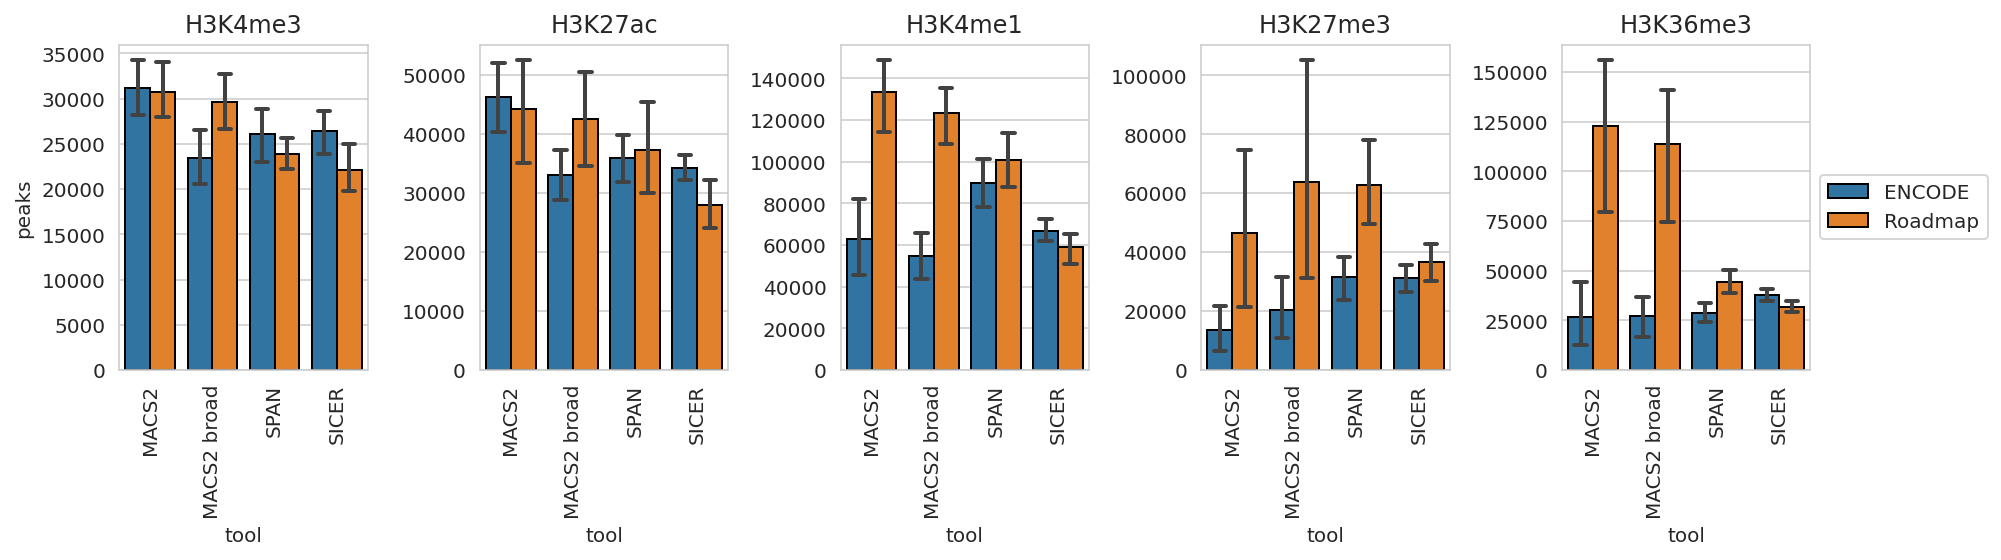

In [13]:
plt.figure(figsize=(14, 4))
axs = [plt.subplot(1, 5, i + 1) for i in range(5)]
for i, m in enumerate(MODIFICATIONS):
    ax = axs[i]
    g_results = sns.barplot(data=df_peaks[df_peaks['modification'] == m], x='tool', y='peaks', ax=ax,
                            hue='dataset',
                            capsize=.2, errwidth=2, edgecolor="black",
                            # palette=TOOLS_PALETTE,
                            order=['MACS2', 'MACS2 broad', 'SPAN', 'SICER'])
    ax.xaxis.set_tick_params(rotation=90)
    ax.title.set_text(m)
    if i > 0:
        ax.set_ylabel(None)
    else:
        ax.set_ylabel('peaks')
    if i < 4:
        ax.legend().set_visible(False)
    else:
        # Put a legend to the right of the current axis
        ax.legend(loc='center left', bbox_to_anchor=(1, 0.5))

    # ax.set_ylim(0, 1.9e7)
plt.tight_layout()
# plt.savefig(GSE26320_PATH_HG38 + f'/pics/library_mapped_detailed_all.pdf', bbox_inches='tight', dpi=300)
plt.show()

## Compute BAM coverage

In [309]:
def load_bams(path, modifications, cells, replicates, control='Input'):
    df_bams = pd.DataFrame(columns=['bam_file', 'modification', 'cell', 'replicate', 'reads'], dtype=object)
    for f in tqdm(os.listdir(path)):
        if not f.endswith('.bam'):
            continue
        cell = next((c for c in cells if c in f), None)
        rep = next((r for r in replicates if r in f), None)
        mod = next((m for m in modifications if m in f), None)
        if mod is None and control is not None and control in f:
            mod = 'Control'
        if cell and mod and rep is not None:
            # # Limit cells
            # if cell not in ['GM12878', 'K562', 'Huvec', 'TCell', 'BCell', 'Monocyte']:
            #     continue
            file = os.path.join(path, f)
            reads = ! samtools view -F 0x04 -c {file}
            reads = int(reads[0])
            df_bams.loc[len(df_bams)] = (file, mod, cell, rep, reads)
    return df_bams


In [310]:
df_encode_bams = load_bams(GSE26320_PATH + '/bams', MODIFICATIONS, GSE26320_CELLS, GSE26320_REPS, 'Input')
df_encode_bams['dataset'] = 'ENCODE'
df_encode_bams

  0%|          | 0/206 [00:00<?, ?it/s]

,bam_file,modification,cell,replicate,reads,dataset
0,/home/jetbrains/data/2023_GSE26320/bams/GSM646...,H3K36me3,NHLF,rep1,14385159,ENCODE
1,/home/jetbrains/data/2023_GSE26320/bams/GSM646...,H3K36me3,NHEK,rep2,7569713,ENCODE
2,/home/jetbrains/data/2023_GSE26320/bams/GSM646...,H3K27ac,NHEK,rep1,9377615,ENCODE
3,/home/jetbrains/data/2023_GSE26320/bams/GSM646...,H3K27me3,HSMM,rep2,8356060,ENCODE
4,/home/jetbrains/data/2023_GSE26320/bams/GSM646...,H3K4me1,K562,rep2,7777248,ENCODE
...,...,...,...,...,...,...
98,/home/jetbrains/data/2023_GSE26320/bams/GSM646...,Control,GM12878,rep1,5699825,ENCODE
99,/home/jetbrains/data/2023_GSE26320/bams/GSM646...,H3K4me3,NHEK,rep1,8169225,ENCODE
100,/home/jetbrains/data/2023_GSE26320/bams/GSM646...,Control,H1,rep2,2998695,ENCODE
101,/home/jetbrains/data/2023_GSE26320/bams/GSM646...,Control,HSMM,rep2,7218491,ENCODE


In [311]:
df_immune_bams = load_bams(IMMUNE_PATH + '/bams', MODIFICATIONS, IMMUNE_CELLS, IMMUNE_REPS, 'Control')
df_immune_bams['dataset'] = 'Roadmap'
df_immune_bams

  0%|          | 0/113 [00:00<?, ?it/s]

,bam_file,modification,cell,replicate,reads,dataset
0,/home/jetbrains/data/2023_Immune/bams/CD4ABT_C...,Control,CD4ABT,rep2,30734164,Roadmap
1,/home/jetbrains/data/2023_Immune/bams/CD4_Cont...,Control,CD4,,42504697,Roadmap
2,/home/jetbrains/data/2023_Immune/bams/TCell_Co...,Control,TCell,,35331343,Roadmap
3,/home/jetbrains/data/2023_Immune/bams/CD34_H3K...,H3K4me3,CD34,rep2,13539143,Roadmap
4,/home/jetbrains/data/2023_Immune/bams/CD34_H3K...,H3K27me3,CD34,,18465977,Roadmap
5,/home/jetbrains/data/2023_Immune/bams/NK_H3K4m...,H3K4me1,NK,,21502380,Roadmap
6,/home/jetbrains/data/2023_Immune/bams/CD4_H3K4...,H3K4me1,CD4,,20428604,Roadmap
7,/home/jetbrains/data/2023_Immune/bams/BCell_H3...,H3K27ac,BCell,,21067933,Roadmap
8,/home/jetbrains/data/2023_Immune/bams/CD34_H3K...,H3K27me3,CD34,rep2,15812841,Roadmap
9,/home/jetbrains/data/2023_Immune/bams/CD4_H3K2...,H3K27ac,CD4,,14516237,Roadmap


In [312]:
df_bams = pd.concat([df_encode_bams, df_immune_bams]).reset_index(drop=True)
df_bams = df_bams.loc[[(m, c, r) not in OUTLIERS for _, (m, c, r) in df_bams[['modification', 'cell', 'replicate']].iterrows()]].copy()

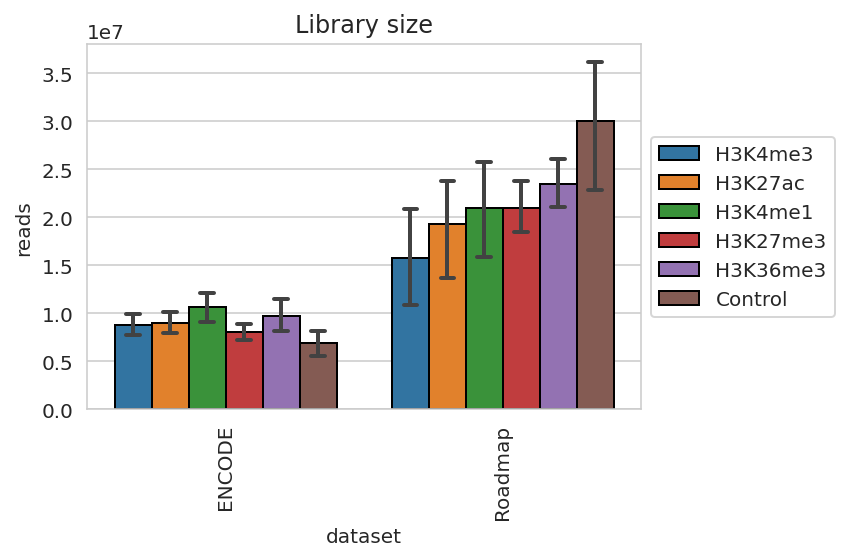

In [313]:
plt.figure(figsize=(6, 4))
ax = plt.axes()
g_results = sns.barplot(data=df_bams,
                        hue='modification', x='dataset', y='reads', ax=ax,
                        capsize=.05, errwidth=2, edgecolor="black",
                        hue_order=MODIFICATIONS+['Control']
                        )
ax.set_title('Library size')
# Put a legend to the right of the current axis
g_results.axes.legend(loc='center left', bbox_to_anchor=(1, 0.5))
ax.xaxis.set_tick_params(rotation=90)

plt.tight_layout()
plt.show()

# Find control tracks

In [315]:
! mkdir -p {DOWNSAMPLE_DIR}/bams
controls = []
control_reads = []

for _, (ds, m, c, r) in tqdm(
        df_bams[['dataset', 'modification', 'cell', 'replicate']].iterrows()):
    if m == 'Control':
        controls.append(None)
        control_reads.append(None)
        continue
    # # Limit cells
    # if c not in ['GM12878', 'K562', 'Huvec', 'TCell', 'BCell', 'Monocyte']:
    #     controls.append(None)
    #     control_reads.append(None)
    #     continue
    print(ds, m, c, r)
    t = df_bams[(df_bams['dataset'] == ds) & (df_bams['modification'] == 'Control') & (df_bams['cell'] == c)]
    tr = t[t['replicate'] == r]
    bam, reads = None, None
    if len(tr) == 1:
        bam = tr['bam_file'].values[0]
        reads = tr['reads'].values[0]
    elif len(t) == 1:
        bam = t['bam_file'].values[0]
        reads = t['reads'].values[0]
    controls.append(bam)
    control_reads.append(reads)
    if bam is None:
        print('No control', ds, m, c, r)
        continue

df_bams['control_file'] = controls
df_bams['control_reads'] = control_reads
df_bams.sample(3)

0it [00:00, ?it/s]

ENCODE H3K36me3 NHLF rep1
ENCODE H3K36me3 NHEK rep2
ENCODE H3K27ac NHEK rep1
ENCODE H3K27me3 HSMM rep2
ENCODE H3K4me1 K562 rep2
ENCODE H3K4me3 K562 rep2
ENCODE H3K27ac HepG2 rep2
ENCODE H3K36me3 Huvec rep1
ENCODE H3K4me3 HSMM rep1
ENCODE H3K27ac HMEC rep1
ENCODE H3K4me1 GM12878 rep1
ENCODE H3K4me1 HSMM rep1
ENCODE H3K4me1 HMEC rep1
ENCODE H3K27ac Huvec rep1
ENCODE H3K27ac GM12878 rep2
ENCODE H3K27me3 NHLF rep1
ENCODE H3K27ac NHLF rep2
ENCODE H3K4me3 HMEC rep2
ENCODE H3K27ac Huvec rep2
ENCODE H3K4me3 NHEK rep2
ENCODE H3K4me1 H1 rep1
ENCODE H3K27ac HepG2 rep1
ENCODE H3K27ac NHLF rep1
ENCODE H3K27ac HSMM rep1
ENCODE H3K36me3 NHLF rep2
ENCODE H3K4me3 K562 rep1
ENCODE H3K27me3 HepG2 rep2
ENCODE H3K36me3 HSMM rep2
ENCODE H3K27me3 HMEC rep2
ENCODE H3K27me3 K562 rep2
ENCODE H3K36me3 GM12878 rep1
ENCODE H3K27me3 NHEK rep1
ENCODE H3K4me3 HMEC rep1
ENCODE H3K27me3 HSMM rep1
ENCODE H3K4me1 HMEC rep2
ENCODE H3K36me3 H1 rep2
ENCODE H3K27me3 H1 rep1
ENCODE H3K36me3 HSMM rep1
ENCODE H3K36me3 HepG2 rep

,bam_file,modification,cell,replicate,reads,dataset,control_file,control_reads
99,/home/jetbrains/data/2023_GSE26320/bams/GSM646...,H3K4me3,NHEK,rep1,8169225,ENCODE,/home/jetbrains/data/2023_GSE26320/bams/GSM646...,8094298.0
156,/home/jetbrains/data/2023_Immune/bams/CD34_H3K...,H3K36me3,CD34,,20291379,Roadmap,/home/jetbrains/data/2023_Immune/bams/CD34_Con...,43022044.0
14,/home/jetbrains/data/2023_GSE26320/bams/GSM646...,H3K4me1,HSMM,rep1,8080332,ENCODE,/home/jetbrains/data/2023_GSE26320/bams/GSM646...,10745462.0


# Mix control

In [337]:
# MIX_DIR = os.path.expanduser('~/data/2023_mix_chr1')
MIX_DIR = os.path.expanduser('~/data/2023_mix')
MIX_SIGNAL_FRACTIONS = [0.7, 0.5, 0.2, 0.1]

In [317]:
# ! mkdir -p {MIX_DIR}/bams
# 
# tf = tempfile.mktemp()
# 
# mixtures = []
# for _, (ds, m, c, r, bam_file, control_file, reads, control_reads) in tqdm(
#         df_bams[df_bams['modification'] != 'Control'][
#             ['dataset', 'modification', 'cell', 'replicate', 'bam_file', 'control_file', 'reads', 'control_reads']
#         ].iterrows()):
#     # Limit cells
#     if c not in ['GM12878', 'K562', 'Huvec', 'TCell', 'BCell', 'Monocyte']:
#         continue    
#     print(ds, m, c, r)
#     control_name = os.path.basename(control_file)
#     ! ln -sf {control_file} {MIX_DIR}/bams/{control_name}
#     
#     for fraction in MIX_SIGNAL_FRACTIONS:
#         print(fraction)
#         result_file = f'{MIX_DIR}/bams/{m}_{c}_{r}_{fraction}.bam'
#         print(result_file)
#         mixtures.append((ds, m, c, r, fraction, result_file))
#         if os.path.exists(result_file):
#             continue
#         control_fraction = min(1.0, (1.0 - fraction) * reads / control_reads)
#         ! samtools view -@ 4 -H {bam_file} > {tf}.sam
#         ! samtools view -@ 4 -s {fraction} {bam_file} >> {tf}.sam
#         ! samtools view -@ 4 -s {control_fraction} {control_file} >> {tf}.sam
#         ! samtools view -S -b {tf}.sam > {tf}.bam
#         ! samtools sort {tf}.bam -o {result_file}
#         ! rm {tf}.sam {tf}.bam
#     
# df_mixtures = pd.DataFrame(mixtures, columns=['dataset', 'modification', 'cell', 'replicate', 'fraction', 'bam_file'])
# del mixtures
# df_mixtures.sample(3)        

In [319]:
! mkdir -p {MIX_DIR}/bams

tf = tempfile.mktemp()
tab = '\t'

mixtures = []
for _, (ds, m, c, r, bam_file, control_file, reads, control_reads) in tqdm(list(
        df_bams[df_bams['modification'] != 'Control'][
            ['dataset', 'modification', 'cell', 'replicate', 'bam_file', 'control_file', 'reads', 'control_reads']
        ].iterrows())):
    # # Limit cells
    # if c not in ['GM12878', 'K562', 'Huvec', 'TCell', 'BCell', 'Monocyte']:
    #     continue
    print(ds, m, c, r)
    control_name = os.path.basename(control_file)
    if not os.path.exists(f'{MIX_DIR}/bams/{control_name}'):
        print('Control')
        ! samtools view -@ 4 -H {control_file} > {tf}.sam
        ! samtools view -@ 4 {control_file} | grep "chr1{tab}" >> {tf}.sam
        ! samtools view -S -b {tf}.sam > {tf}.bam
        ! samtools sort {tf}.bam -o {MIX_DIR}/bams/{control_name}
        ! rm {tf}.sam {tf}.bam
        # ! ln -sf {control_file} {MIX_DIR}/bams/{control_name}

    for fraction in MIX_SIGNAL_FRACTIONS:
        print(fraction)
        result_file = f'{MIX_DIR}/bams/{m}_{c}_{r}_{fraction}.bam'
        print(result_file)
        mixtures.append((ds, m, c, r, fraction, result_file))
        if os.path.exists(result_file):
            continue
        control_fraction = min(1.0, (1.0 - fraction) * reads / control_reads)
        ! samtools view -@ 4 -H {bam_file} > {tf}.sam
        ! samtools view -@ 4 -s {fraction} {bam_file} | grep "chr1{tab}" >> {tf}.sam
        ! samtools view -@ 4 -s {control_fraction} {control_file} | grep "chr1{tab}" >> {tf}.sam
        ! samtools view -S -b {tf}.sam > {tf}.bam
        ! samtools sort {tf}.bam -o {result_file}
        ! rm {tf}.sam {tf}.bam

df_mixtures = pd.DataFrame(mixtures, columns=['dataset', 'modification', 'cell', 'replicate', 'fraction', 'bam_file'])
del mixtures
df_mixtures.sample(3)

  0%|          | 0/125 [00:00<?, ?it/s]

ENCODE H3K36me3 NHLF rep1
0.7
/home/jetbrains/data/2023_mix_chr1/bams/H3K36me3_NHLF_rep1_0.7.bam
0.5
/home/jetbrains/data/2023_mix_chr1/bams/H3K36me3_NHLF_rep1_0.5.bam
0.2
/home/jetbrains/data/2023_mix_chr1/bams/H3K36me3_NHLF_rep1_0.2.bam
0.1
/home/jetbrains/data/2023_mix_chr1/bams/H3K36me3_NHLF_rep1_0.1.bam
ENCODE H3K36me3 NHEK rep2
0.7
/home/jetbrains/data/2023_mix_chr1/bams/H3K36me3_NHEK_rep2_0.7.bam
0.5
/home/jetbrains/data/2023_mix_chr1/bams/H3K36me3_NHEK_rep2_0.5.bam
0.2
/home/jetbrains/data/2023_mix_chr1/bams/H3K36me3_NHEK_rep2_0.2.bam
0.1
/home/jetbrains/data/2023_mix_chr1/bams/H3K36me3_NHEK_rep2_0.1.bam
ENCODE H3K27ac NHEK rep1
0.7
/home/jetbrains/data/2023_mix_chr1/bams/H3K27ac_NHEK_rep1_0.7.bam
0.5
/home/jetbrains/data/2023_mix_chr1/bams/H3K27ac_NHEK_rep1_0.5.bam
0.2
/home/jetbrains/data/2023_mix_chr1/bams/H3K27ac_NHEK_rep1_0.2.bam
0.1
/home/jetbrains/data/2023_mix_chr1/bams/H3K27ac_NHEK_rep1_0.1.bam
ENCODE H3K27me3 HSMM rep2
0.7
/home/jetbrains/data/2023_mix_chr1/bams/H3K27

,dataset,modification,cell,replicate,fraction,bam_file
108,ENCODE,H3K36me3,HSMM,rep2,0.7,/home/jetbrains/data/2023_mix_chr1/bams/H3K36m...
21,ENCODE,H3K4me3,K562,rep2,0.5,/home/jetbrains/data/2023_mix_chr1/bams/H3K4me...
254,ENCODE,H3K4me3,GM12878,rep1,0.2,/home/jetbrains/data/2023_mix_chr1/bams/H3K4me...


## Peak calling and visualization

```
conda activate snakemake
snakemake -p -s ~/work/chipseq-smk-pipeline/Snakefile all --cores all  --use-conda  --directory $(pwd) --config genome=hg38 fastq_dir=$(pwd) start_with_bams=True bams_dir=bams macs2=True span=True sicer=False --rerun-trigger mtime && \
snakemake -p -s ~/work/chipseq-smk-pipeline/Snakefile all --cores all  --use-conda  --directory $(pwd) --config genome=hg38 fastq_dir=$(pwd) start_with_bams=True bams_dir=bams macs2=True macs2_mode=broad macs2_params="--broad --broad-cutoff=0.1" macs2_suffix="broad0.1"  span=False sicer=True --rerun-trigger mtime; 

```

# Analyze results

In [338]:
! mkdir -p {MIX_DIR}/original_chr1

mixed_peaks_df = load_peaks_path(MIX_DIR, MODIFICATIONS, GSE26320_CELLS + IMMUNE_CELLS, GSE26320_REPS + IMMUNE_REPS)
mixed_peaks_df['dataset'] = 'ENCODE'
mixed_peaks_df.loc[mixed_peaks_df['cell'].isin(IMMUNE_CELLS), 'dataset'] = 'Roadmap'
mixed_peaks_df['fraction'] = 0
for fraction in MIX_SIGNAL_FRACTIONS:
    mixed_peaks_df.loc[(mixed_peaks_df['file'].str.contains(f'_{fraction}_')) |
                       (mixed_peaks_df['file'].str.contains(f'_{fraction}-')), 'fraction'] = fraction
t = df_peaks[(df_peaks['cell'].isin(mixed_peaks_df['cell'].unique())) &
             (df_peaks['replicate'].isin(mixed_peaks_df['replicate'].unique()))][[
    'file', 'modification', 'cell', 'replicate', 'peaks', 'tool', 'dataset']].copy()
t['fraction'] = 1.0
# Processing original files
t = df_peaks[(df_peaks['cell'].isin(mixed_peaks_df['cell'].unique())) &
             (df_peaks['replicate'].isin(mixed_peaks_df['replicate'].unique()))][[
    'file', 'modification', 'cell', 'replicate', 'peaks', 'tool', 'dataset']].copy()
t['fraction'] = 1.0
# chr1_files = []
# chr1_peaks = []
# for file in tqdm(t['file']):
#     chr1_file = f'{MIX_DIR}/original_chr1/{os.path.basename(file)}'
#     if not os.path.exists(chr1_file):
#         tab = '\t'
#         ! cat {file} | grep "chr1{tab}" > {chr1_file}
#     chr1_files.append(chr1_file)
#     chr1_peaks.append(lines(chr1_file))
# t['file'] = chr1_files
# t['peaks'] = chr1_peaks
mixed_peaks_df = pd.concat([mixed_peaks_df, t]).reset_index(drop=True)
mixed_peaks_df.sample(3)

  0%|          | 0/1376 [00:00<?, ?it/s]

MACS2 172


  0%|          | 0/1376 [00:00<?, ?it/s]

MACS2 broad 172


  0%|          | 0/172 [00:00<?, ?it/s]

SICER 172


  0%|          | 0/175 [00:00<?, ?it/s]

SPAN 172


,file,modification,cell,replicate,peaks,tool,dataset,fraction
699,/home/jetbrains/data/2023_GSE26320/macs2/GSM64...,H3K4me1,GM12878,rep1,46817,MACS2,ENCODE,1.0
581,/home/jetbrains/data/2023_mix/span/H3K4me3_GM1...,H3K4me3,GM12878,rep1,26687,SPAN,ENCODE,0.7
91,/home/jetbrains/data/2023_mix/macs2/H3K4me1_Mo...,H3K4me1,Monocyte,,112740,MACS2,Roadmap,0.7


## Peaks number

In [339]:
def plot_modified(df, y, line):
    for ds in ['ENCODE', 'Roadmap']:
        print(ds)
        plt.figure(figsize=(15, 3))
        axs = [plt.subplot(1, 5, i + 1) for i in range(5)]

        for i, m in enumerate(MODIFICATIONS):
            ax = axs[i]
            t = df[(df['dataset'] == ds) & (df['modification'] == m)].copy()
            fractions = sorted(df['fraction'].unique(), reverse=True)
            t['j'] = 0
            for j, fraction in enumerate(fractions):
                t.loc[t['fraction'] == fraction, 'j'] = j
            if line:
                sns.lineplot(data=t,
                             x='j', y=y, hue='tool',
                             hue_order=['MACS2', 'MACS2 broad', 'SICER', 'SPAN'],
                             palette=TOOLS_PALETTE,
                             ax=ax,
                             errorbar='se', marker='o', markersize=10
                             )
                ax.set_xticks(range(len(fractions)), minor=False)
                ax.set_xticklabels([str(f) for f in fractions])
                ax.set_xlabel('fraction')
                # We could use just invert axis, but this won't make linear dots
                # ax.invert_xaxis()
            else:
                sns.barplot(data=t,
                                    x='tool', y=y, hue='fraction', ax=ax,
                                    capsize=.1, errwidth=2, edgecolor="black",
                                    order=['MACS2', 'MACS2 broad', 'SPAN', 'SICER'],
                                    hue_order = sorted(df['fraction'].unique(), reverse=True),
                                    )
            # ax.set_ylim(0, 110_000)
            ax.xaxis.set_tick_params(rotation=90)
            ax.title.set_text(m)
            if i > 0:
                ax.set_ylabel(None)
            if i < 4:
                ax.legend().set_visible(False)
            else:
                # Put a legend to the right of the current axis
                ax.legend(loc='center left', bbox_to_anchor=(1, 0.5))    

        plt.tight_layout()
        plt.show()

Mixed
ENCODE


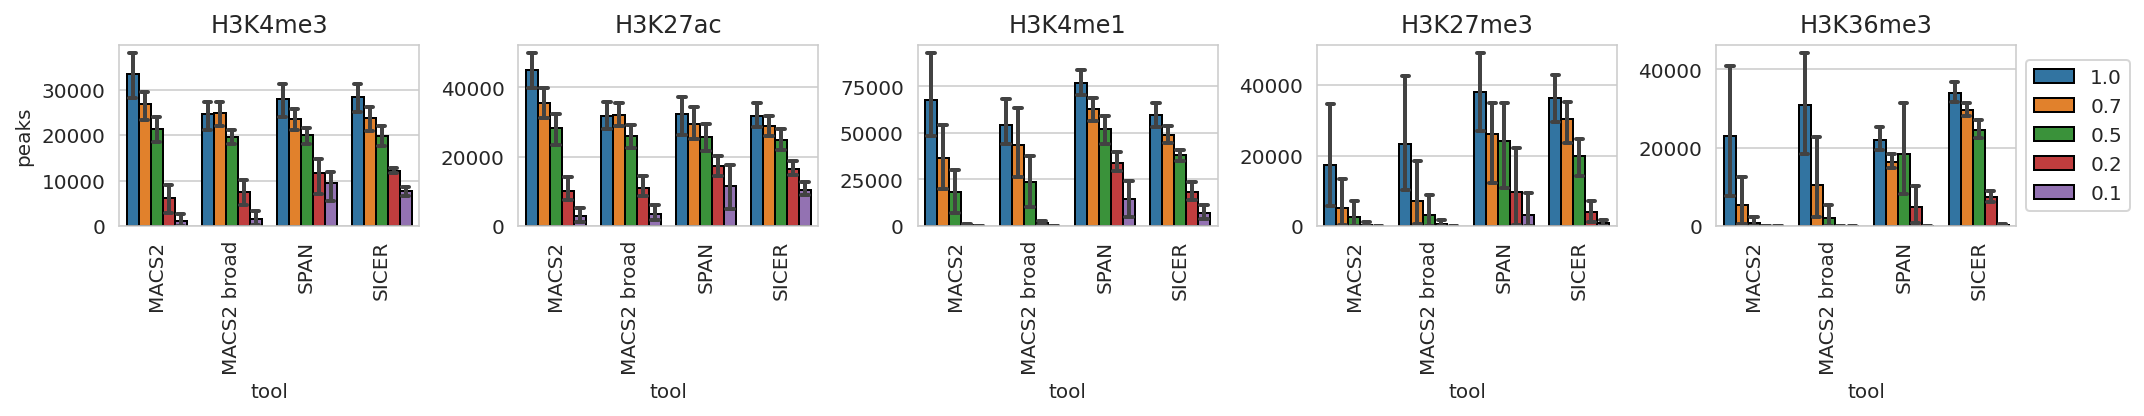

Roadmap


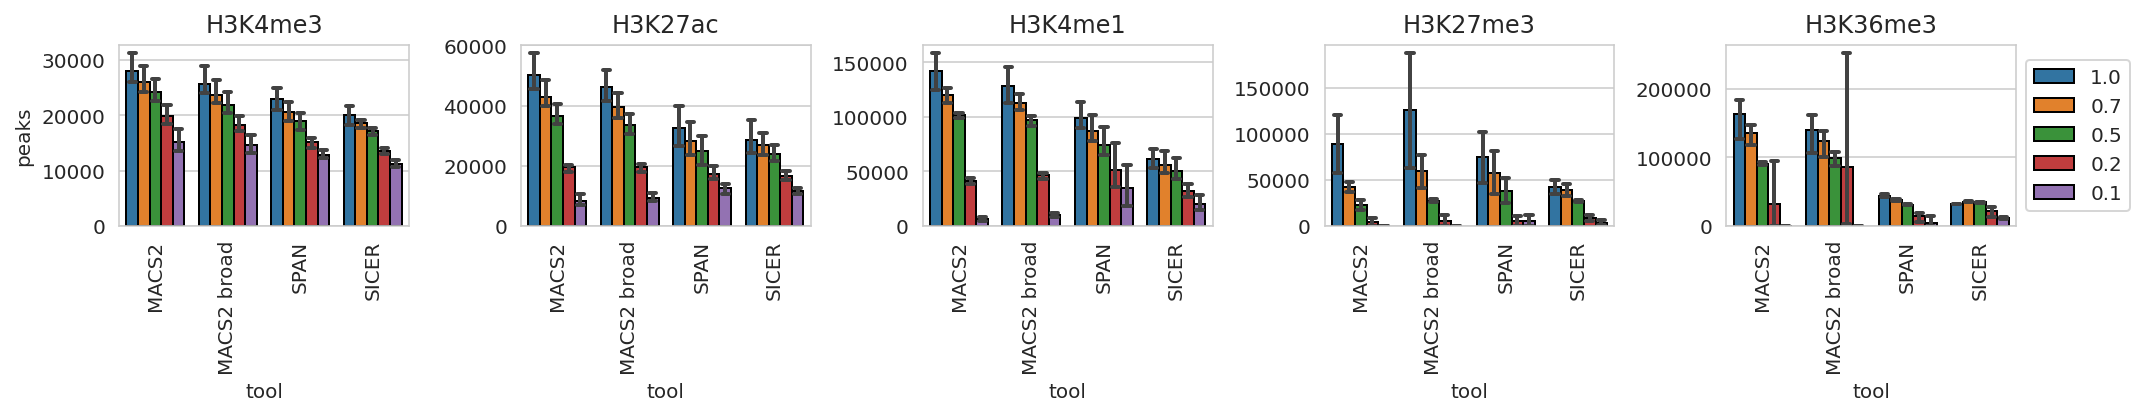

In [340]:
print('Mixed')
plot_modified(mixed_peaks_df, 'peaks', False)

## Jaccard vs original

In [341]:
def overlap_vs_original(df):
    tf = tempfile.mktemp()
    overlaps = []
    for _, (ds, m, c, r, fraction, tool, file) in tqdm(df[df['fraction'] != 1.0][[
        'dataset', 'modification', 'cell', 'replicate', 'fraction', 'tool', 'file'
    ]].iterrows()):
        t = df[(df['fraction'] == 1.0) &
                           (df['dataset'] == ds) &
                           (df['modification'] == m) &
                           (df['cell'] == c) &
                           (df['replicate'] == r) &
                           (df['tool'] == tool)]
        if len(t) == 0:
            print('No original peaks for', ds, m, c, r, tool)
            continue
        original_file = t['file'].values[0]
        original_peaks = lines(original_file)
        original_peaks_len = int(bedl(original_file).sum())
        peaks = lines(file)
        peaks_len = int(bedl(file).sum())
        !bedtools intersect -a {original_file} -b {file} -wa -u > {tf}
        original_peaks_overlap = lines(tf)
        !bedtools intersect -b {original_file} -a {file} -wa -u > {tf}
        peaks_overlap = lines(tf)
        !bedtools intersect -a {original_file} -b {file} -wo > {tf}
        overlap_len = int(last_col(tf).sum())
        overlaps.append((ds, m, c, r, fraction, tool, 
                         peaks, peaks_len, original_peaks, original_peaks_len,
                         peaks_overlap, original_peaks_overlap, overlap_len, 
                         d(overlap_len, peaks_len + original_peaks_len - overlap_len)))
        
    return pd.DataFrame(overlaps, columns=[
        'dataset', 'modification', 'cell', 'replicate', 'fraction', 'tool', 
        'peaks', 'peaks_len', 'original_peaks', 'original_peaks_len',
        'peaks_overlap', 'original_peaks_overlap', 'overlap_len', 'jaccard'
    ])

In [342]:
mixed_peaks_overlap_df = overlap_vs_original(mixed_peaks_df)
# Add 1.0 and 0.0 fraction
for _, (ds, m, c, r, t) in list(
        mixed_peaks_overlap_df[
            ['dataset', 'modification', 'cell', 'replicate', 'tool']].drop_duplicates().iterrows()):
    mixed_peaks_overlap_df.loc[len(mixed_peaks_overlap_df)] = \
        [ds, m, c, r, 0.0, t] + [None] * (len(mixed_peaks_overlap_df.columns) - 7) + [0.0]
    mixed_peaks_overlap_df.loc[len(mixed_peaks_overlap_df)] = \
        [ds, m, c, r, 1.0, t] + [None] * (len(mixed_peaks_overlap_df.columns) - 7) + [1.0]
mixed_peaks_overlap_df.sample(3)

0it [00:00, ?it/s]

,dataset,modification,cell,replicate,fraction,tool,peaks,peaks_len,original_peaks,original_peaks_len,peaks_overlap,original_peaks_overlap,overlap_len,jaccard
449,ENCODE,H3K4me1,GM12878,rep2,0.2,SICER,11830,44809170,51620,196154180,11830,10342,42967918,0.217015
790,Roadmap,H3K27ac,Monocyte,,0.0,MACS2 broad,None,None,None,None,None,None,None,0.000000
307,ENCODE,H3K4me1,K562,rep2,0.7,MACS2 broad,34414,23861091,47075,77771933,34358,23914,23763099,0.305164


In [343]:
from datetime import datetime
now = datetime.now().isoformat(timespec='minutes')
rfile = f'{MIX_DIR}/mixed_peaks_overlap_df_{now}.csv.gz'
print(rfile)
mixed_peaks_overlap_df.to_csv(rfile, compression='gzip', index=None)

/home/jetbrains/data/2023_mix/mixed_peaks_overlap_df_2023-11-26T18:54.csv.gz


In [344]:
# mixed_peaks_overlap_df = pd.read_csv('~/data/2023_mix/mixed_peaks_overlap_df_2023-11-22T23:50.csv.gz', compression='gzip')
# mixed_peaks_overlap_df.sample(3)

In [345]:
# print('Mixed control')
# plot_modified(mixed_peaks_overlap_df[mixed_peaks_overlap_df['cell'].isin(
#     ['GM12878', 'K562', 'Huvec', 'TCell', 'BCell', 'Monocyte'])], 'jaccard', True)

Mixed control
ENCODE


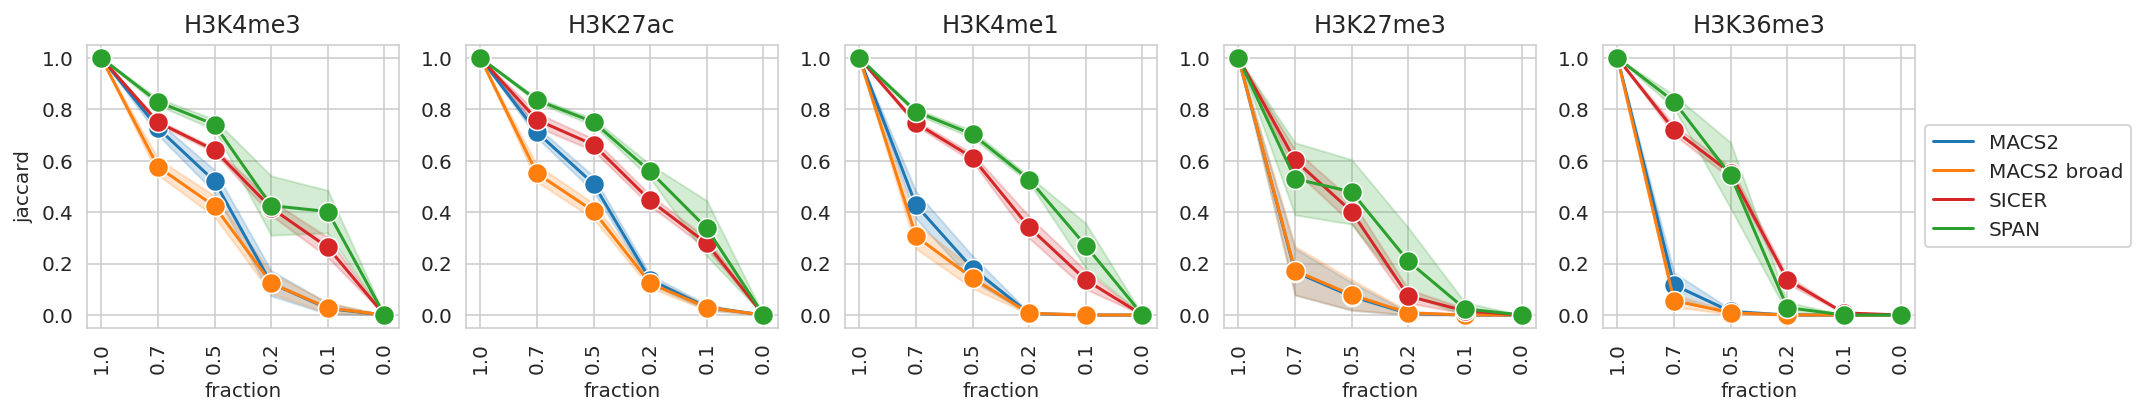

Roadmap


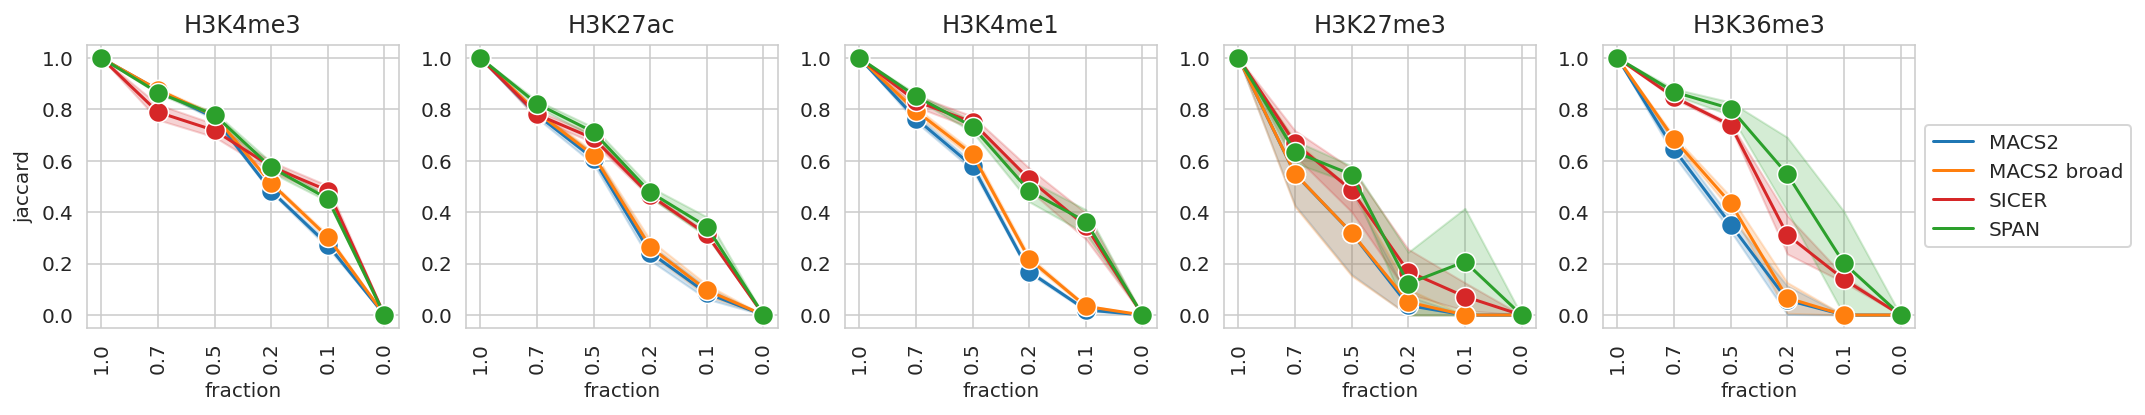

In [346]:
print('Mixed control')
plot_modified(mixed_peaks_overlap_df, 'jaccard', True)

In [347]:
def compute_auc(df, x):
    rows = []
    for (ds, m, c, r, tool), t in df.groupby(['dataset', 'modification', 'cell', 'replicate', 'tool']):
        t = t.copy()
        t.sort_values(by=['fraction'], inplace=True)
        auc = 0
        fraction_prev = 0
        value_prev = 0
        for _, (fraction, value) in t[['fraction', x]].iterrows():
            auc += (fraction - fraction_prev) * (value + value_prev) / 2
            fraction_prev, value_prev = fraction, value
        rows.append((ds, m, c, r, tool, auc))
    return pd.DataFrame(data=rows, columns=['dataset', 'modification', 'cell', 'replicate', 'tool', 'auc'])

In [348]:
mixed_peaks_overlap_auc_df = compute_auc(mixed_peaks_overlap_df, 'jaccard')
mixed_peaks_overlap_auc_df.sample(3)

,dataset,modification,cell,replicate,tool,auc
67,ENCODE,H3K36me3,K562,rep2,SPAN,0.554782
89,ENCODE,H3K4me1,K562,rep2,MACS2 broad,0.250134
64,ENCODE,H3K36me3,K562,rep2,MACS2,0.189456


ENCODE


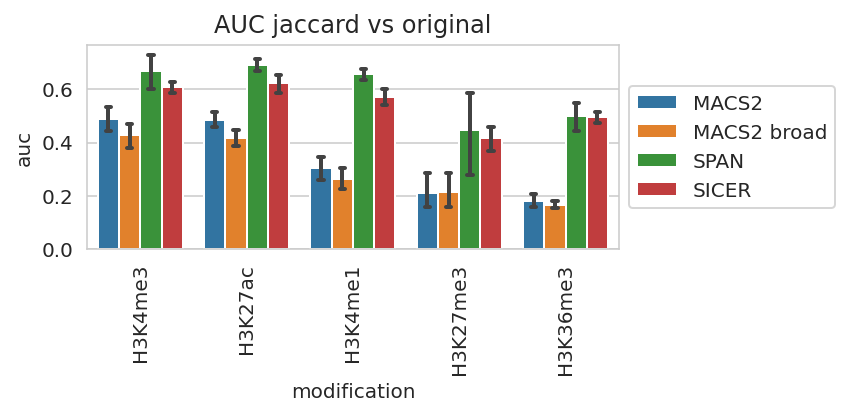

Roadmap


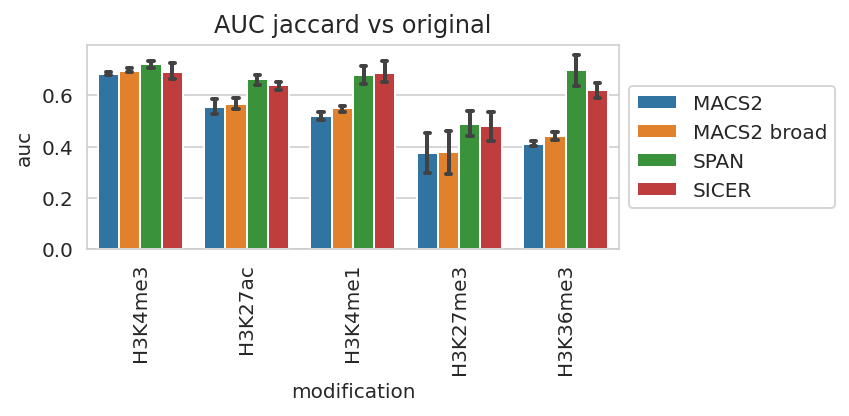

In [349]:
for ds in ['ENCODE', 'Roadmap']:
    print(ds)
    plt.figure(figsize=(6, 3))
    ax = plt.axes()
    ax.title.set_text('AUC jaccard vs original')
    g_results = sns.barplot(data=mixed_peaks_overlap_auc_df[mixed_peaks_overlap_auc_df['dataset']==ds], 
                            x='modification', y='auc',
                            hue='tool',
                            ax=ax,
                            capsize=.05, errwidth=2,
                            order=MODIFICATIONS,
                            hue_order=['MACS2', 'MACS2 broad', 'SPAN', 'SICER'],
                            )
    ax.xaxis.set_tick_params(rotation=90)
    # Put a legend to the right of the current axis
    ax.legend(loc='center left', bbox_to_anchor=(1, 0.5))
    plt.tight_layout()
    plt.show()